In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.stem import WordNetLemmatizer
from gensim.models import word2vec

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from adjustText import adjust_text
%matplotlib inline

pd.set_option('display.max_columns', 100)
pd.set_option("display.max_colwidth", 500)

nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('omw-1.4')

df = pd.read_csv("../data/multidimensional.csv")
df[["doc_statement", "doc_ground_truth_value"]].head()

STOP_WORDS = nltk.corpus.stopwords.words()

[nltk_data] Downloading package stopwords to /home/jiqi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jiqi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jiqi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


<AxesSubplot:xlabel='doc_ground_truth_value', ylabel='Count'>

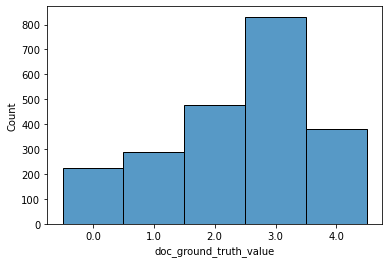

In [2]:
ground_truth = df["doc_ground_truth_value"].astype("string").sort_values()
sns.histplot(data=ground_truth, bins=5)

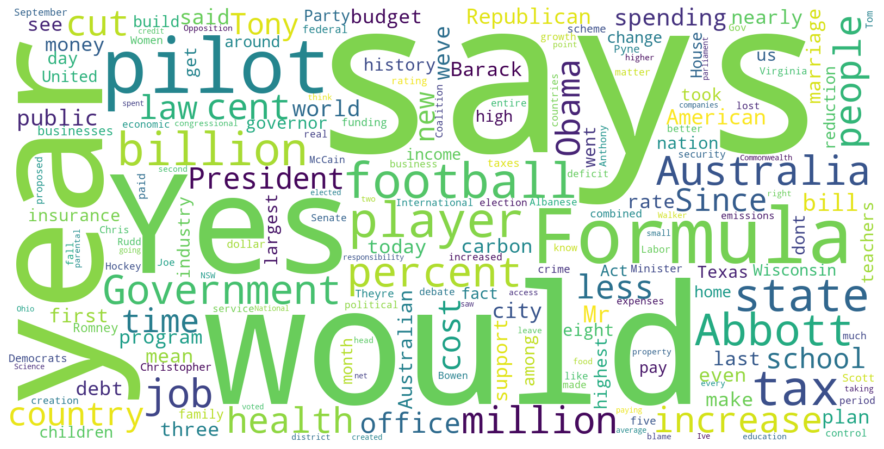

In [3]:
# word cloud overview
wc = WordCloud(collocations=False, background_color="white", width=1600, height=800, stopwords=STOP_WORDS).generate(" ".join(df["doc_statement"]))
plt.figure(figsize=(16, 8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [4]:
# text preprocessing
def clean_text(t):
    text = re.sub("([^\s\w]|_)+", "", t)
    text = re.sub("^\d+\s|\s\d+\s|\s\d+$", "", text)
    text = text.lower()
    text = text.split(" ")

    for word in list(text):
        if word in STOP_WORDS or len(word) < 2:
            text.remove(word)
    
    text = map(WordNetLemmatizer().lemmatize, text)

    return list(text)

corpus = df["doc_statement"]
corpus = corpus.dropna(how="any")
corpus = corpus.apply(clean_text)
corpus.head()

0    [state, matter, state, constitution, provides, marriage, responsibility, commonwealth, parliament, know, commonwealth, parliament, recently, voted, subject, fairly, decisive, margin, decided, stick, existing, marriage, act]
1                                                                                        [mr, abbott, seems, suffering, little, bit, amnesia, mr, rudd, saidwhen, health, minister, cutbillion, public, hospital, budget, australia]
2                                                                      [australia, eight, country, given, rating, aaa, stable, outlook, three, credit, rating, agenciesthese, real, fact, amount, negative, political, spin, change]
3                                                                                                                                                                                                                              [yes]
4                                                                                   

In [5]:
# word embedding
model = word2vec.Word2Vec(corpus, vector_size=100, window=20, workers=4, min_count=20)
print(len(model.wv.index_to_key))
print(model.wv.index_to_key)
model.wv["state"]

323
['say', 'would', 'tax', 'year', 'player', 'football', 'pilot', 'formula', 'yes', 'state', 'government', 'abbott', 'australia', 'country', 'job', 'health', 'increase', 'people', 'law', 'le', 'cut', 'cent', 'president', 'obama', 'tony', 'office', 'time', 'spending', 'new', 'cost', 'school', 'bill', 'mr', 'since', 'world', 'public', 'republican', 'city', 'business', 'said', 'three', 'debt', 'weve', 'barack', 'first', 'mean', 'program', 'carbon', 'rate', 'even', 'support', 'american', 'see', 'budget', 'money', 'australian', 'make', 'today', 'plan', 'marriage', 'governor', 'eight', 'last', 'took', 'woman', 'day', 'texas', 'insurance', 'went', 'nation', 'history', 'u', 'highest', 'industry', 'get', 'largest', 'month', 'christopher', 'five', 'among', 'change', 'pyne', 'high', 'scott', 'income', 'wisconsin', 'party', 'family', 'act', 'united', 'reduction', 'house', 'around', 'romney', 'dollar', 'funding', 'democrat', 'theyre', 'paid', 'scheme', 'combined', 'crime', 'minister', 'federal', '

array([-0.17743862, -0.15392084, -0.08726898, -0.08819737, -0.1102262 ,
       -0.47594973,  0.10685978,  0.5519811 , -0.24354726, -0.23985562,
       -0.1457787 , -0.26907474, -0.20109013, -0.09829359, -0.01000277,
       -0.29776672, -0.2295312 , -0.43534714, -0.04415013, -0.41012883,
        0.00093638,  0.01199109, -0.02462869, -0.1054927 , -0.15567748,
        0.28651989, -0.2169178 , -0.13369939, -0.38278127, -0.05977903,
        0.07039608,  0.3090924 , -0.05608274, -0.0535326 , -0.03441627,
        0.14631078,  0.03050127, -0.27621427, -0.32583493, -0.5396386 ,
       -0.07458336, -0.2957421 , -0.07381075, -0.09216084,  0.3209352 ,
        0.1677981 , -0.13252923, -0.12753758,  0.12364181,  0.00791886,
        0.04191202, -0.07761031,  0.27913773,  0.00745689,  0.03528092,
        0.03000655, -0.14489001, -0.18011777, -0.2966332 ,  0.3300475 ,
        0.0562924 ,  0.20089872,  0.09824591, -0.38585284, -0.49927786,
        0.20186664,  0.32275566,  0.31534812, -0.22588973,  0.52

In [6]:
# dimension reduction
tokens = []
labels = []

for word in model.wv.index_to_key:
    tokens.append(model.wv[word])
    labels.append(word)

tsne_model = TSNE(n_components=2, init="pca", n_iter=2500)
vectors_2d = tsne_model.fit_transform(tokens)

/home/jiqi/miniconda3/envs/pyvis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/jiqi/miniconda3/envs/pyvis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


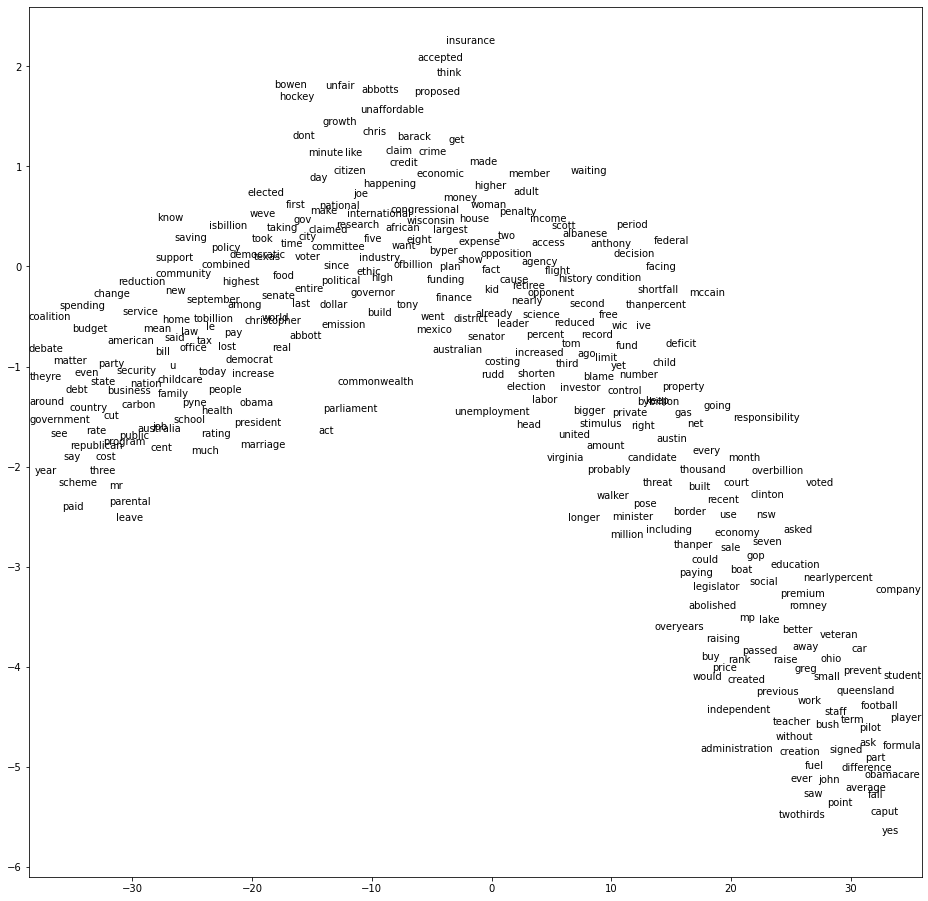

In [11]:
# plot semantic space
x = []
y = []
for v in vectors_2d:
    x.append(v[0])
    y.append(v[1])

plt.figure(figsize=(16, 16))
plt.plot(x, y, "bo", alpha=0)
texts = [plt.text(x[i], y[i], labels[i]) for i in range(len(x))]
adjust_text(texts)
plt.show()